In [1]:
import pandas as pd
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as patches

from matplotlib.dates import DateFormatter
from scipy.ndimage import gaussian_filter, zoom
from datetime import timedelta, datetime

billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week
billboard_hot_100.head()

C:\Users\cutie\AppData\Local\Temp\ipykernel_39656\523238995.py:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week


,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year,week
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958,37
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958,37
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958,37
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958,37
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958,37


In [2]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

plt.rcParams.update({'font.size': 15})

## Similarities between normalized trajectories for songs that reached top 1-10

In [8]:
def hamming_distance(s1, s2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

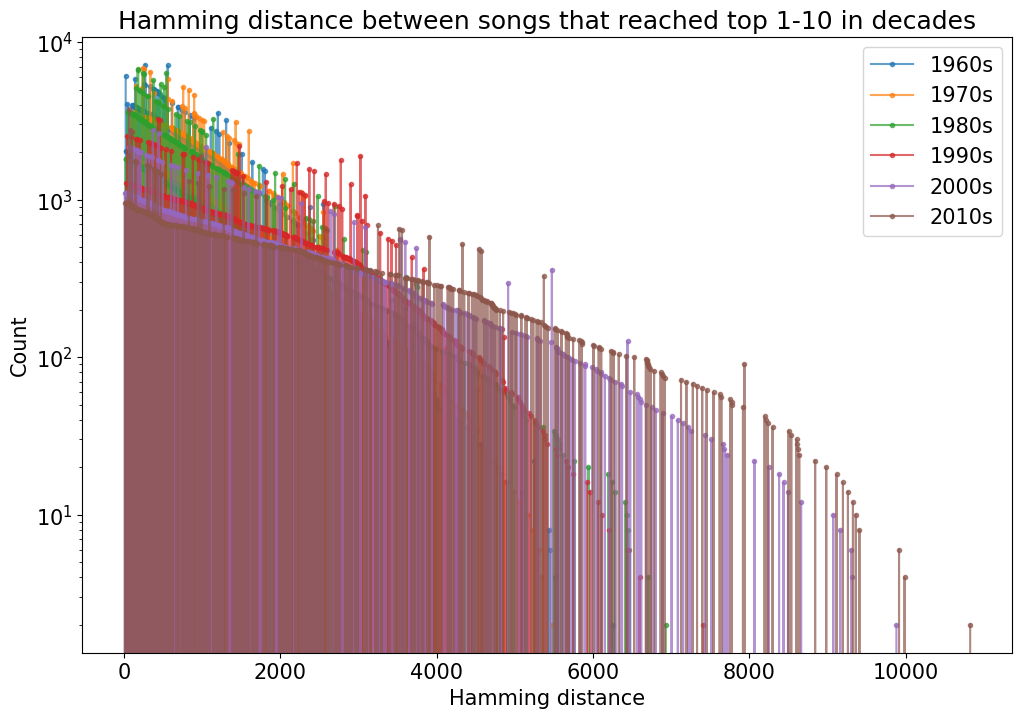

In [22]:
plt.figure(figsize=(12, 8))

for year in range(1960, 2020, 10):
    # take songs that appeared at least once at postion 1-10 in the decade
    top_10_positions_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & (billboard_hot_100["position"] >= 1) &\
            (billboard_hot_100["position"] <= 10)][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week"]]

    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].merge(
    billboard_hot_100[["artist", "song_name", "weeks_on_chart",
            "position", "first_day_of_the_week"]], on=["artist", "song_name"], how="left")

    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)

    min_first_week = top_10_positions_in_decade.index.min().to_pydatetime()

    grouped = top_10_positions_in_decade.groupby(["artist", "song_name"])
    rows_to_add = []
    for name, group in grouped:
        first_week = group.index.min().to_pydatetime()
        max_week = group.index.max().to_pydatetime()
        min_week = group.index.min().to_pydatetime()
        # take only songs from this decade
        if min_week < dateutil.parser.parse(f"{year}-01-01") or max_week > dateutil.parser.parse(f"{year + 9}-12-31"):
            continue
        rows_to_add.append([])
        for row_index, row in group.iterrows():
            if row_index == max_week:
                week_date = row_index + timedelta(weeks=1)
                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add[-1].append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": int(((min_first_week + timedelta(
                            days=(week_date + timedelta(weeks=1) - first_week).days)) - min_first_week).days / 7),
                    })
                    week_date += timedelta(weeks=1)
            row["first_day_of_the_week"] = int(((min_first_week + timedelta(
                days=(row_index - first_week).days)) - min_first_week).days / 7)
            rows_to_add[-1].append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": row["position"],
                    "first_day_of_the_week": row["first_day_of_the_week"],
                })
    hamming_distances = []
    for row1 in rows_to_add:
        for row2 in rows_to_add:
            if row1 != row2:
                hamming_distances.append(hamming_distance(row1, row2))

    hist, edges = np.histogram(hamming_distances, bins=np.max(hamming_distances))
    middle_ponts = [(edges[i] + edges[i - 1])/2 for i in range(1, len(edges))]
    plt.plot(middle_ponts, hist, label=f'{year}s', marker='.', alpha=0.7)

plt.xlabel("Hamming distance")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Hamming distance between songs that reached top 1-10 in decades")
plt.legend()
plt.savefig("figures/top_1_10_trajectories_similarities_decades.pdf", format="pdf")
plt.show()